# Aprendizaje Automático

## Práctica 5: Evaluación de modelos - Bias y varianza

En esta práctica vamos a utilizar la regresión lineal regularizada para estudiar los conceptos de bias y varianza y comprender mejor cómo debemos realizar la evaluación de modelos con las particiones de datos adecuada (train, validación y test).

### Índice de la práctica

- [Lectura de datos](#Lectura-de-datos)
- [Particionamiento de datos](#particionamiento)
- [Visualización de datos](#visualizacion)
- [Regresión lineal - Curva de aprendizaje](#reglineal)
- [Regresión polinomial - Curva de aprendizaje](#regpolinomial)
    - [Seleccionando el valor de lambda usando el conjunto de validación](#lambdasel)
- [Particionamiento de los datos en particiones de train/val/test](#Particionamiento-de-los-datos-en-particiones-de-train/val/test)
- [Pipelines de Python](#pipelines)
- [GridSearchCV](#gridsearch)

Importamos todas las librerías que vamos a utilizar durante la segunda práctica.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize


# Helper function to test the correctness of the solutions
def test_nb(var, val, msg=""):
    if var == val:
        print("✔️ Test passed.")
    else:
        print("❌ Test failed. " + msg)
        raise AssertionError(msg)


%matplotlib inline

## Lectura de datos

Vamos a comenzar esta práctica definiendo una función para leer un archivo que contiene los datos.  La función debe recibir como parámetro de entrada el nombre del fichero a leer (`file_name`) y el símbolo utilizado para separar los valores de las variables del problema (`delimiter`). Además de leer los datos, la función debe crear las matrices de `X` e `y`. Asumiremos que la última columna contiene la salida para cada ejemplo.

Define la función `read_data`.

In [30]:
def read_data(file_name, delimiter):
    # Lee los datos
    datos= np.loadtxt(file_name, delimiter=delimiter)
    print(datos[:5])
    X = datos[:,:-1]
    y = datos[:,-1].reshape(-1,1)
    return X, y

Utiliza la función implementada para leer el fichero `datos_agua.txt`. Los datos contenidos en este fichero corresponden a un problema en el que se debe predecir la cantidad de agua que atraviesa una presa en base al nivel de agua. El archivo contiene el histórico de los cambios en el nivel de agua (variables de entrada) así como la cantidad de agua que atraviesa la presa (variable de salida).

In [31]:
# Guarda los datos en la variable datos
X, y = read_data('datos_agua.txt',';')


# Muestra las dimensiones de los datos y los 5 primeros ejemplos
print(X.shape, y.shape)

[[-48.05882945   2.80896507]
 [ 34.05450539  31.32355102]
 [-47.01007574  10.62365619]
 [  7.01350208   7.62765885]
 [  1.97449674   8.08727989]]
(54, 1) (54, 1)


## Particionamiento de datos <a id="particionamiento"></a>

Para realizar esta práctica, vamos a particionar los datos en tres conjuntos: Train, Validación y Test. Aunque podríamos realizarlo manualmente con `numpy`, en este caso vamos a hacer uso de scikit-learn y su función [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Utiliza esta función para particionar el conjunto de datos inicial en tres conjuntos. Utiliza los porcentajes de validación y test del 20% y reordena los datos aleatoriamente, con semilla 5. Necesitarás importar la función.

> **Nota:** Para que el particionamiento cuadre con el test posterior, deberías dividir primero el conjunto original en train y test (20% para test), y posteriormente, el conjunto de train volverlo a dividir en train y validación (estableciendo el tamaño de validación al mismo tamaño del conjunto test anterior).

In [32]:
from sklearn.model_selection import train_test_split

# 80% para train_full, 20% para test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

#Divide el 80% restante (train_full)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=5)

In [33]:
test_nb(y_train.size, 32, 'Tamaño de train incorrecto')
test_nb(y_val.size, 11, 'Tamaño de val incorrecto')
test_nb(y_test.size, 11, 'Tamaño de test incorrecto')
test_nb(np.round(X_train[1], 4), -14.5415, 'Valores de train incorrectos')
test_nb(np.round(X_val[1], 4),  34.0545, 'Valores de val incorrectos')
test_nb(np.round(X_test[1], 4), -23.6696, 'Valores de test incorrectos')

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## Visualización de datos <a id="visualizacion"></a>

Ahora vamos a crear una gráfica para visualizar los datos, a la que podremos pasarle los diferentes conjuntos de datos para pintarlos en diferente color.

In [35]:
def plot_data(X_train=None, y_train=None, X_val=None, y_val=None, X_test=None, y_test=None,
             X_label=None, y_label=None, ax=None):
    
    # Si no se pasa un manejador de una figura se crea una
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # Recordatorio scatter:
    # # Utiliza marker= para establecer el marcador
    # # Utiliza c= para establecer el color
    # # Utiliza label= para establecer la etiqueta de los datos
    # # Debes utilizar la variable ax y utilizar su método scatter
    if X_train is not None:
        ax.scatter(X_train, y_train, marker='x', c='blue', label='Train')

    if X_val is not None:
        ax.scatter(X_val, y_val, marker='x', c='red', label='Val')

    if X_test is not None:
        ax.scatter(X_test, y_test, marker='x', c='green', label='Test')

    # Establecemos las etiquetas de los ejes
    if X_label is not None:
        ax.set_xlabel(X_label)
    if y_label is not None:
        ax.set_ylabel(y_label)

    # Añadimos la leyenda
    ax.legend(frameon=True, fancybox=True, loc=0);
    return ax
    

Utiliza la función anterior para visualizar los tres conjuntos particionados: train, val y test.

Debes replicar esta figura:

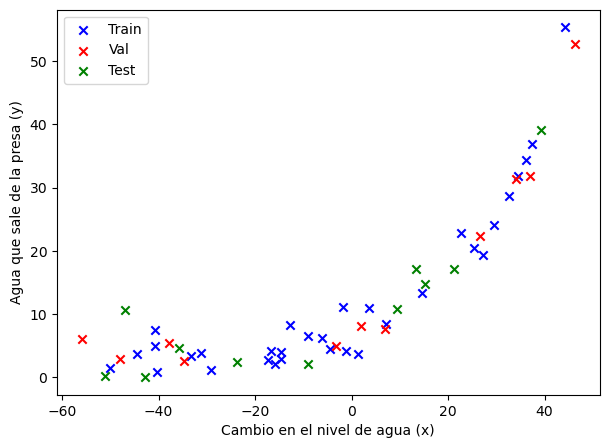

<Axes: xlabel='Cambio en el nivel de agua (x)', ylabel='Agua que sale de la presa (y)'>

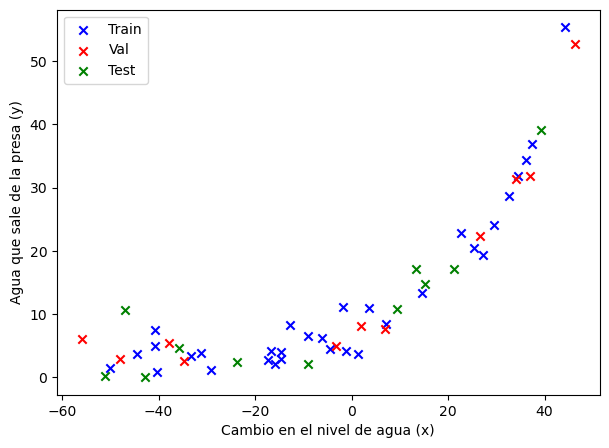

In [36]:
# Llama a la función para visualizar los tres conjuntos
plot_data(X_train, y_train, X_val, y_val, X_test, y_test, 
          X_label='Cambio en el nivel de agua (x)', 
          y_label='Agua que sale de la presa (y)')

## Regresión lineal <a id="reglineal"></a>

Como tenemos un problema de regresión, vamos a ajustar un modelo de regresión lineal. Para ello, vamos a hacer uso de la clase [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) de `scikit-learn`, que nos sirve para llevar a cabo una regresión lineal **sin regularización**. Más adelante, veremos qué clase nos permite llevar a cabo una regresión lineal con regularización. 

Aprende un modelo de regresión lineal utilizando los datos de entrenamiento y calcula los errores cometidos en entretamiento y en test. Para calcular el error cuadrático medio puedes hacer uso de la función [`mean_quared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) de sickit-learn.

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Vamos a comprobar como funciona la regresión lineal en este problema

# Crea el objeto LinearRegression
modelo = LinearRegression()

# Entrena la regresión lineal con los datos de train
modelo.fit(X_train, y_train)

# Calculamos e imprimimos los errores en train / val
# Para ello debes calcular el error cuadrático medio (valor medio de las diferencias entre la predicción y la salida desea) dividido por 2
y_predict_train = modelo.predict(X_train)
y_pred_val = modelo.predict(X_val)

train_err = mean_squared_error(y_train, y_predict_train)
val_err = mean_squared_error(y_val, y_pred_val) 

print('Error en train: {}'.format(train_err))
print('Error en val: {}'.format(val_err))

Error en train: 48.605282587706
Error en val: 88.85454616992024


In [44]:
test_nb(round(train_err, 4), 48.6053, 'Error en train erróneo')
test_nb(round(val_err, 4), 88.8545, 'Error en test erróneo')

✔️ Test passed.
✔️ Test passed.


Vamos a crear ahora una función que nos ayude a pintar la regresión.

In [50]:
# Aquí puedes reutilizar la función para pintar las fronteras de decisión
def plot_linear_regression_sklearn(reg, x_lim, y_lim, ax=None):
    if ax is None:
        fig, ax= plt.subplots(figsize=(8, 6))

    x = np.linspace(*x_lim).reshape(-1, 1)

    # Predecimos las salidas y lo pintamos
    y_pred = reg.predict(x)

    ax.plot(x, y_pred, c='red', lw=2, label='Regresión lineal')
      
    # Establecemos los límites
    ax.set_xlim(*x_lim)       
    ax.set_ylim(*y_lim)      
    return ax 

Utiliza la función definida para pintar tanto los puntos de train, validación y test, como la regresión obtenida sobre ellos.

<Axes: xlabel='Cambio en el nivel de agua (x)', ylabel='Agua que sale de la presa (y)'>

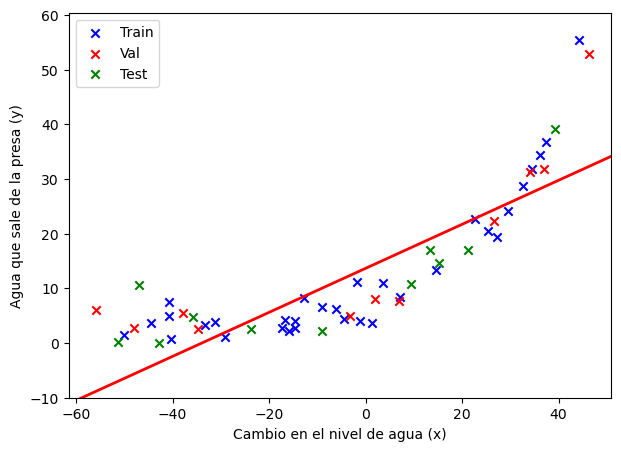

In [51]:
# Definimos los límites
x_lim = (X.min()*1.1, X.max()*1.1)
y_lim = (y.min()-10, y.max()+5)


# 1. Pintamos los puntos de datos y guardamos los ejes 'ax'
ax = plot_data(X_train, y_train, X_val, y_val, X_test, y_test, 
               X_label='Cambio en el nivel de agua (x)', 
               y_label='Agua que sale de la presa (y)')

# 2. Pintamos la regresión lineal sobre los mismos ejes 'ax'
plot_linear_regression_sklearn(modelo, x_lim, y_lim, ax=ax)

### Curva de aprendizaje para la regresión lineal

Ahora vamos a representar las curvas de aprendizaje para la regresión lineal conforme aumenta el número de ejemplos. Debes mostrar el número de ejemplos en el eje x y los errores de train y validación en el eje y. 

Para realizar el ejercicio debes entrenar varios modelos lineales partiendo de un único ejemplo de entrenamiento y añadiendo un ejemplo más cada vez. Posteriormente, debes evaluar el modelo con los datos que se hayan usado para entrenarlo (error de train) y también con los datos que hemos reservado en validación (error de validación). Así, podrás representar la curva con los errores en cada conjunto según aumenta el número de ejemplos con los que se entrena. 

> **Nota:** Ten en cuenta que para el error de train solo se debe utilizar el conjunto de datos con el que se haya entrenado el modelo. 



Una vez realizado el ejercicio, responde a las siguientes preguntas:
* ¿Cómo evoluciona el error? (train/val)
* ¿Por qué no obtenemos una buena generalización?
* ¿Es un problema de bias alto o de varianza alta? 

* *RESPONDER AQUÍ A LA PREGUNTAS*

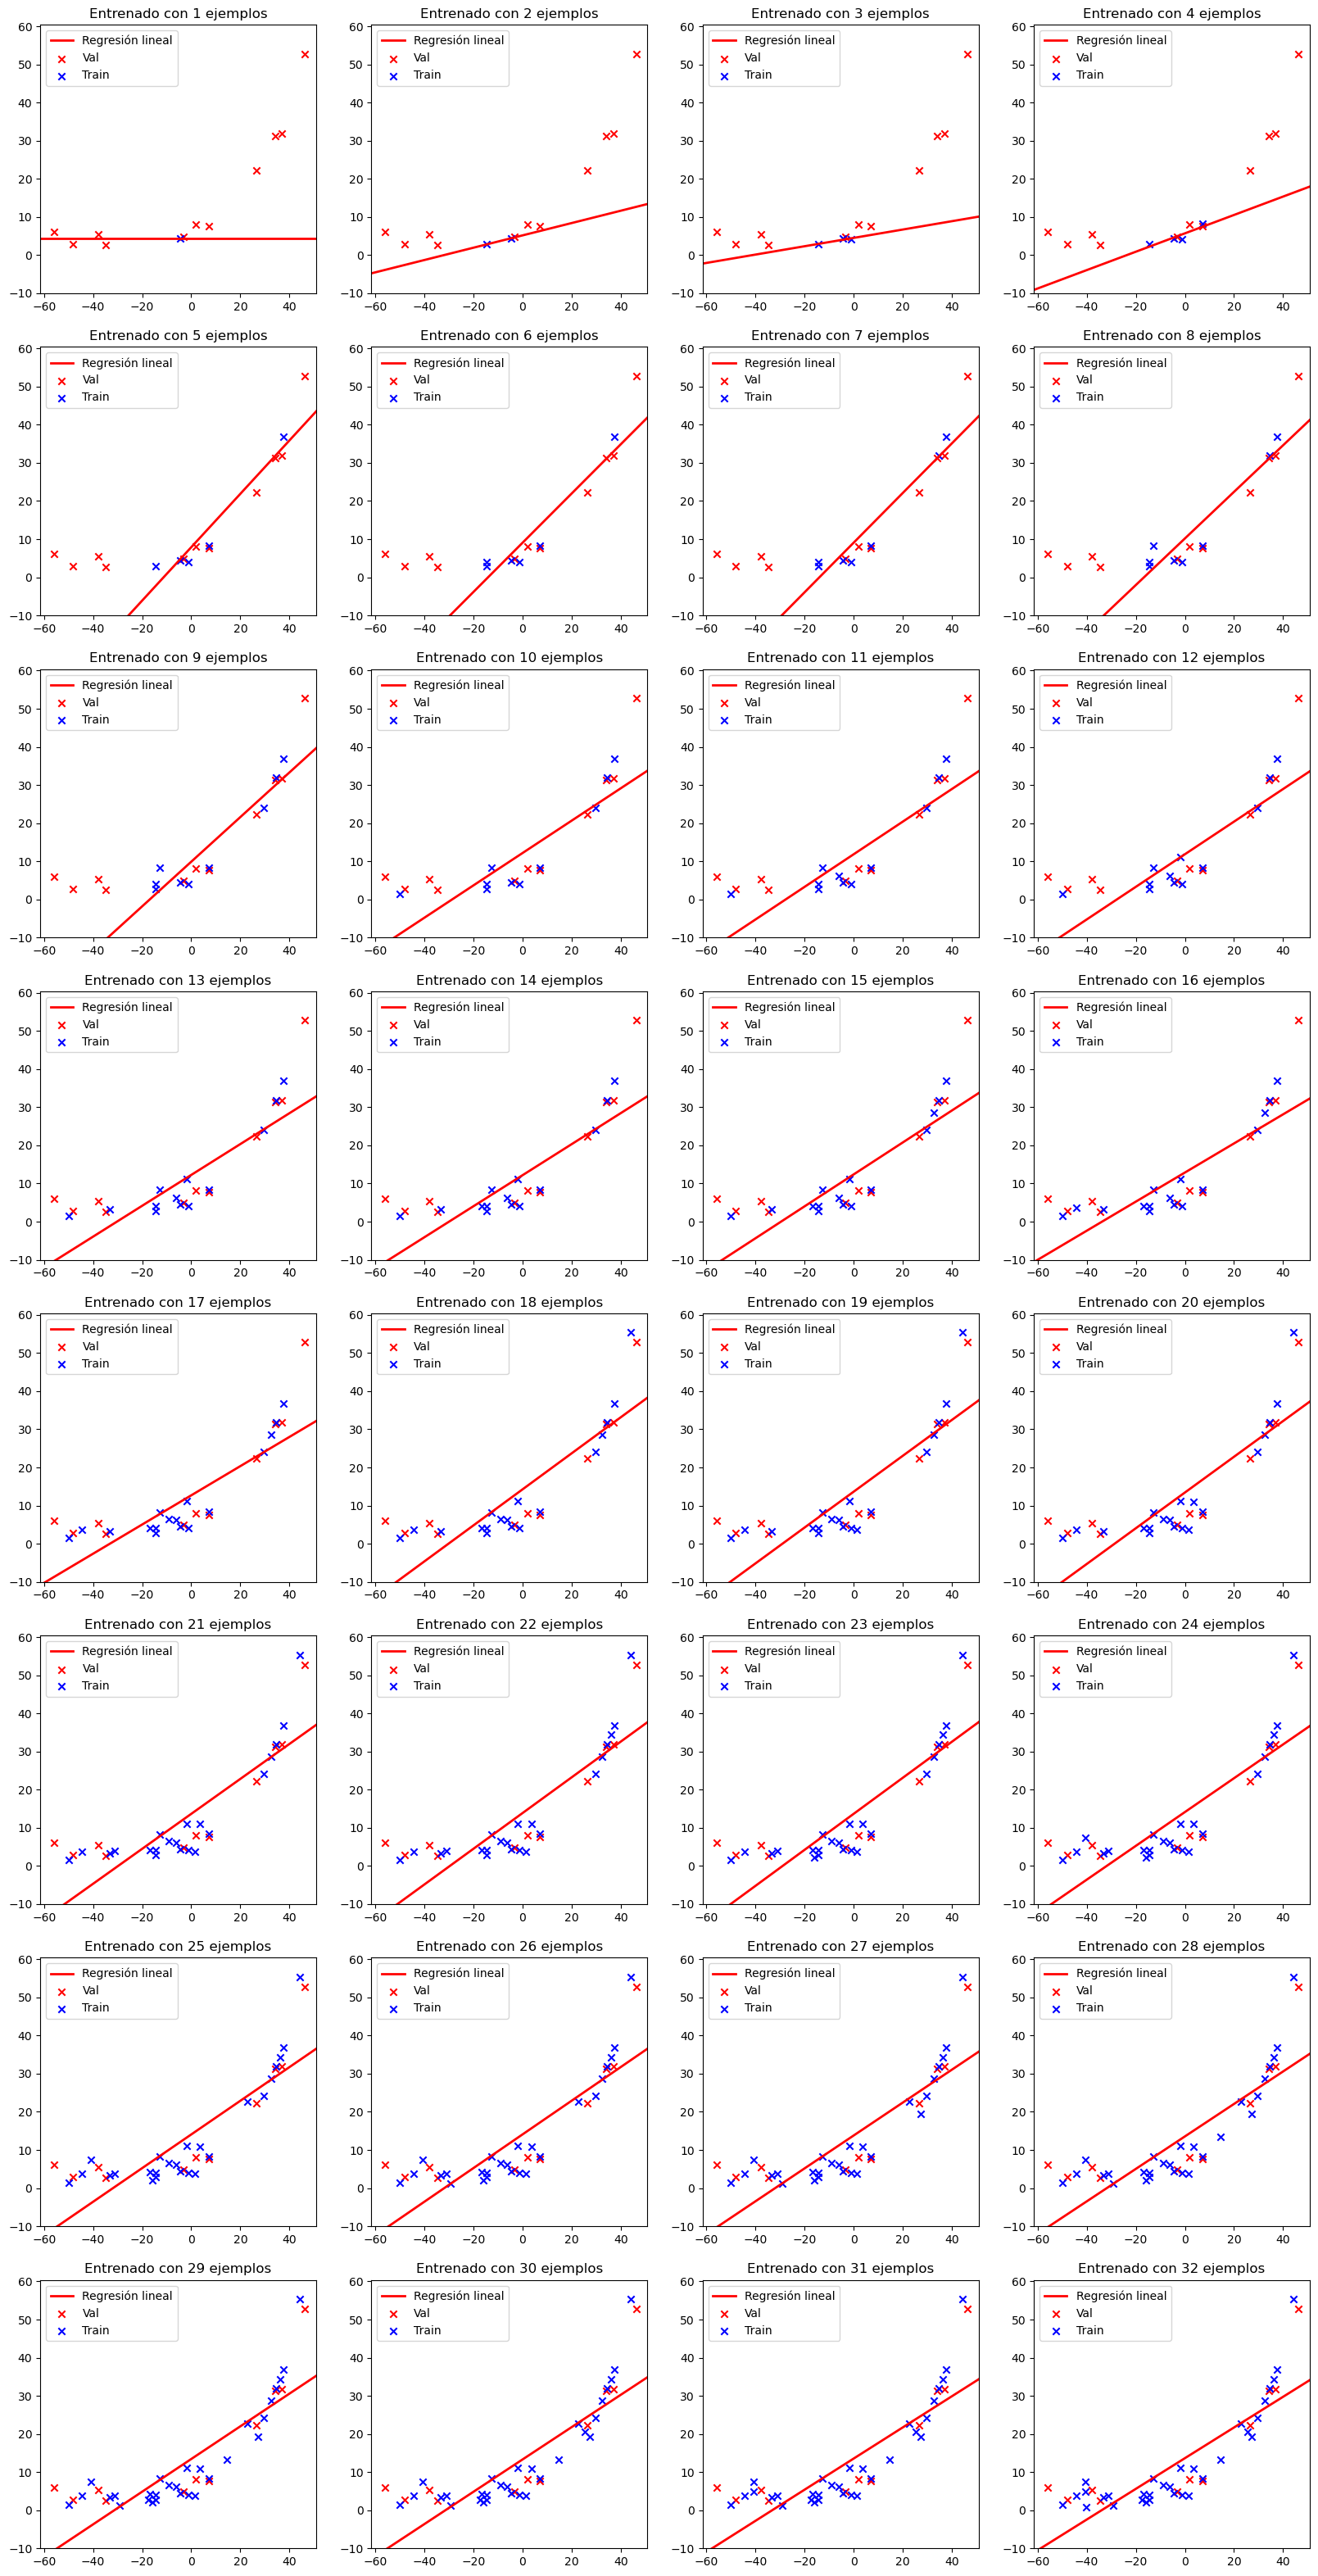

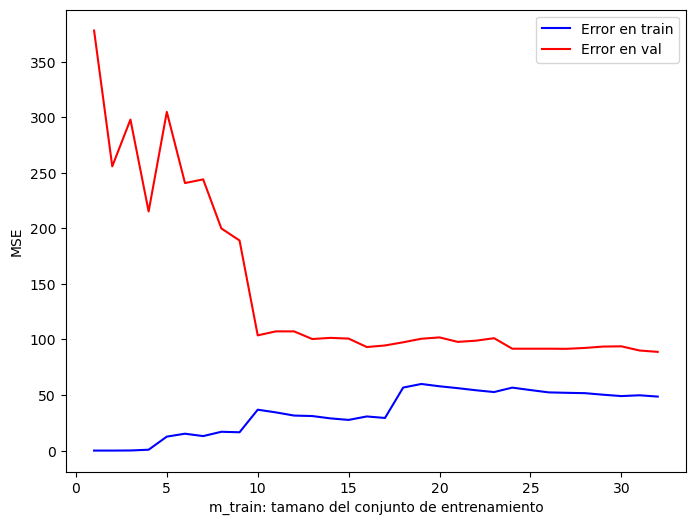

In [48]:
# Creamos el objeto de regresión lineal
from statistics import mean


modelo = LinearRegression()

# Creamos dos arrays para almacenar los resultados de error en train (train_err) y validación de tamaño m_train x 1 (val_err)
m_train = X_train.shape[0]
train_err = np.zeros(m_train)
val_err = np.zeros(m_train)

# Definimos una figura para pintar todos los resultados
fig, ax = plt.subplots(np.ceil(m_train / 4).astype('int'), 4, figsize=(20, 40)) 

# Comenzamos probando a entrenar la regresión con un solo ejemplo y realizamos la misma tarea hasta m_train
for i in range(0, m_train):
    # Ajustamos la regresión con los i primeros ejemplos (filas)
    modelo.fit(X_train[:i+1,:], y_train[:i+1])
    # Calculamos el error en train (SOBRE LOS i PRIMEROS EJEMPLOS) y validación (COMPLETO)
    y_predict_train = modelo.predict(X_train[:i+1,:])
    y_val_pred = modelo.predict(X_val)

    train_err[i] = mean_squared_error(y_train[:i+1], y_predict_train)
    val_err[i] = mean_squared_error(y_val, y_val_pred)

    # Pintamos en cada iteración la misma figura que en el apartado anterior con la recta aprendida en cada ocasión
    # Asegúrate de mostrar siempre todos los puntos de validación, y para train destaca de alguna forma los puntos usados 
    # Pon como título de cada subfigure el número de ejemplos utilizados para entrenar
    # Como hemos definido un subplot, utliza ax.ravel()[i] como eje para pintar la figura
    eje_actual = ax.ravel()[i]
    plot_linear_regression_sklearn(modelo, x_lim,y_lim,ax=eje_actual)
    plot_data(X_val=X_val, y_val=y_val, ax=eje_actual)
    plot_data(X_train=X_train[:i+1], y_train=y_train[:i+1], ax=eje_actual)
    eje_actual.set_title(f'Entrenado con {i+1} ejemplos')


# Ahora con todos los errores en train_err y val_err, pintamos la curva de aprendizaje
# En el eje X debemos tener el número de ejemplos utilizados para el entrenamiento (de 1 a m_train) y en el eje y
# debe de aparecer el error obtenido. Pintamos con diferente color cada error (train/val)
plt.figure(figsize=(8, 6))
eje_x_curva = np.arange(1, m_train + 1)

# Pintamos la curva de error de train
plt.plot(eje_x_curva, train_err, c='blue', label='Error en train')

# Pintamos la curva de error de validación
plt.plot(eje_x_curva, val_err, c='red', label='Error en val')

# Establecemos las etiquetas
plt.xlabel('m_train: tamano del conjunto de entrenamiento')
plt.ylabel('MSE')
plt.legend();

In [49]:
test_nb(list(np.round(train_err, 4)), [ 0.    ,  0.    ,  0.0959,  0.7799, 12.5759, 15.1884, 13.0449,
       16.9242, 16.4847, 36.7953, 34.3794, 31.5145, 31.0905, 28.9781,
       27.6073, 30.7209, 29.366 , 56.7247, 59.9519, 57.8804, 56.1869,
       54.3026, 52.6817, 56.6684, 54.4809, 52.3855, 51.9964, 51.6811,
       50.2815, 49.0546, 49.7707, 48.6053], 'Errores en train erróneos')
test_nb(list(np.round(val_err, 4)), [378.048 , 255.8498, 297.965 , 215.2242, 304.8422, 240.8053,
       244.1115, 199.9358, 189.1174, 103.7043, 107.3116, 107.2907,
       100.4095, 101.457 , 100.796 ,  93.2022,  94.6095,  97.4832,
       100.6663, 101.8662,  97.8498,  98.9231, 101.1632,  91.7015,
        91.6892,  91.6989,  91.6038,  92.4134,  93.623 ,  93.8441,
        90.0794,  88.8545], 'Errores en test erróneos')

✔️ Test passed.
✔️ Test passed.


## Regresión polinomial <a id="regpolinomial"></a>
Vamos a intentar solucionar el problema que tenemos mediante la regresión polinomial, ya que parece que estamos ante un problema cuya solución no es lineal.

Para poder hacer uso de las características polinomiales utilizaremos la clase `PolynomialFeatures` de scikit junto con `StandardScaler` (para normalizar las características tras obtener las polinómicas y que el algoritmo de minimización funcione correctamente).

In [53]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Mapear X_train a características polinómicas y normaliza
# Primero debemos establecer el grado el polinomio que vamos a utilizar
grado = 6
# Crear el objeto de la clase PolynomialFeatures, utiliza include_bias=False ya que con scikit no lo necesitamos
# Crear también el objeto de la clase StandardScaler
poly = PolynomialFeatures(grado, include_bias=False)
scaler = StandardScaler()

# Utiliza fit_transform para obtener el conjunto de datos de train transformado con características polinomiales (guardar en X_train_poly)
X_train_poly = poly.fit_transform(X_train)
# Ahora utiliza el StandardScaler creado con fit_transform para ajustarlo y transformar los datos polinomiales (guardar en X_train_poly)
X_train_poly = scaler.fit_transform(X_train_poly)

# IMPORTANTE!!!!!!!!!!!!!
# DEBES HACER LO MISMO CON LOS CONJUNTOS DE VALIDACIÓN Y TEST; PERO TEN EN
# CUENTA QUE LA MEDIA Y LA DESVIACIÓN ESTÁNDAR A UTILIZAR SON LAS
# CALCULADAS EN TRAIN Y POR TANTO SOLO DEBES USAR TRANSFORM EN LUGAR DE FIT_TRANSFORM

# Mapear X_val a características polinómicas y normalizar (guardar en X_val_poly)
X_val_poly = poly.transform(X_val)
X_val_poly = scaler.transform(X_val_poly)

# Mapear X_test a características polinómicas y normalizar (guardar en X_test_poly)
X_test_poly = poly.transform(X_test)
X_test_poly = scaler.transform(X_test_poly)

Una vez obtenidas las nuevas características, vamos a llevar a cabo una regresión polinomial. Para ello, vamos a volver a hacer uso de la clase [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) de `scikit-learn`. Al igual que antes, obtén los resultados de error en train y en validación. Después dibujaremos el resultado.

In [55]:
# Crear objeto LinearRegression y entrenarlo con los datos de train polinomiales
modelo = LinearRegression()
modelo.fit(X_train_poly,y_train)

# Obtenemos el error para train y validación con la regresión obtenida
# Imprimir errores en train / val (train_err y val_err)
y_predict_train = modelo.predict(X_train_poly)
train_err = mean_squared_error(y_predict_train, y_train)

y_predict_val = modelo.predict(X_val_poly)
val_err = mean_squared_error(y_predict_val, y_val)

print('Error en train: {}'.format(train_err))
print('Error en val: {}'.format(val_err))

Error en train: 4.26434126899133
Error en val: 19.661912464609255


In [56]:
test_nb(round(train_err, 4), 4.2643, 'Error en train erróneo')
test_nb(round(val_err, 4), 19.6619, 'Error en test erróneo')

✔️ Test passed.
✔️ Test passed.


Vamos ahora a modificar la función para pintar la solución del tal forma que podamos pasarle los objetos para obtener las características polinomiales y normalizar las variables.

In [57]:
# Aquí puedes reutilizar la función para pintar las fronteras de decisión
def plot_linear_regression_sklearn(reg, x_lim, y_lim, poly=None, scaler=None, ax=None):
    if ax is None:
        fig, ax= plt.subplots(figsize=(8, 6))

    x = np.linspace(*x_lim).reshape(-1, 1)
    x_plot = x.copy()

    if poly:
        # Generamos las las polinomiales con poly y transform
        x = poly.transform(x)
    if scaler:
        # Normalizamos las variables con el scaler y transform
        x = scaler.transform(x)
    
    y_plot = reg.predict(x)

    ax.plot(x_plot, y_plot, linewidth=2, label='Regresión Polinomial')
    
    # Establecemos los límites
    ax.set_xlim(*x_lim)         
    ax.set_ylim(*y_lim)          
    return ax 

Pinta ahora los ejemplos del problema con la solución de la regresión polinomial.

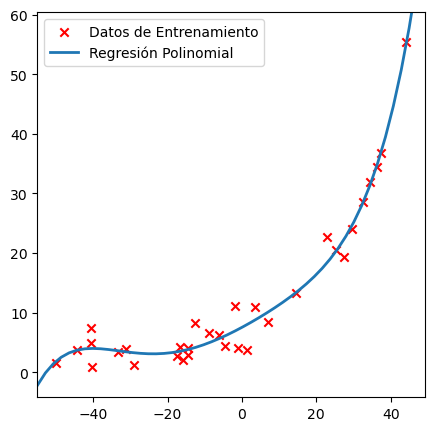

In [58]:

fig, ax = plt.subplots(figsize=(5,5))

x_lim = [X_train.min() - 5, X_train.max() + 5]
y_lim = [y_train.min() - 5, y_train.max() + 5]

ax.scatter(X_train, y_train, marker='x', c='r', label='Datos de Entrenamiento')
plot_linear_regression_sklearn(modelo, x_lim, y_lim, poly, scaler, ax)


ax.legend()
plt.show()

### Curva de aprendizaje para la regresión polinomial
Debes realizar el mismo ejercicio que para la regresión lineal, pero esta vez haciendo uso de las nuevas características polinómicas, ¿Qué ocurre ahora?

* *EXPLICA AQUÍ TU RESPUESTA*

(0.0, 1000.0)

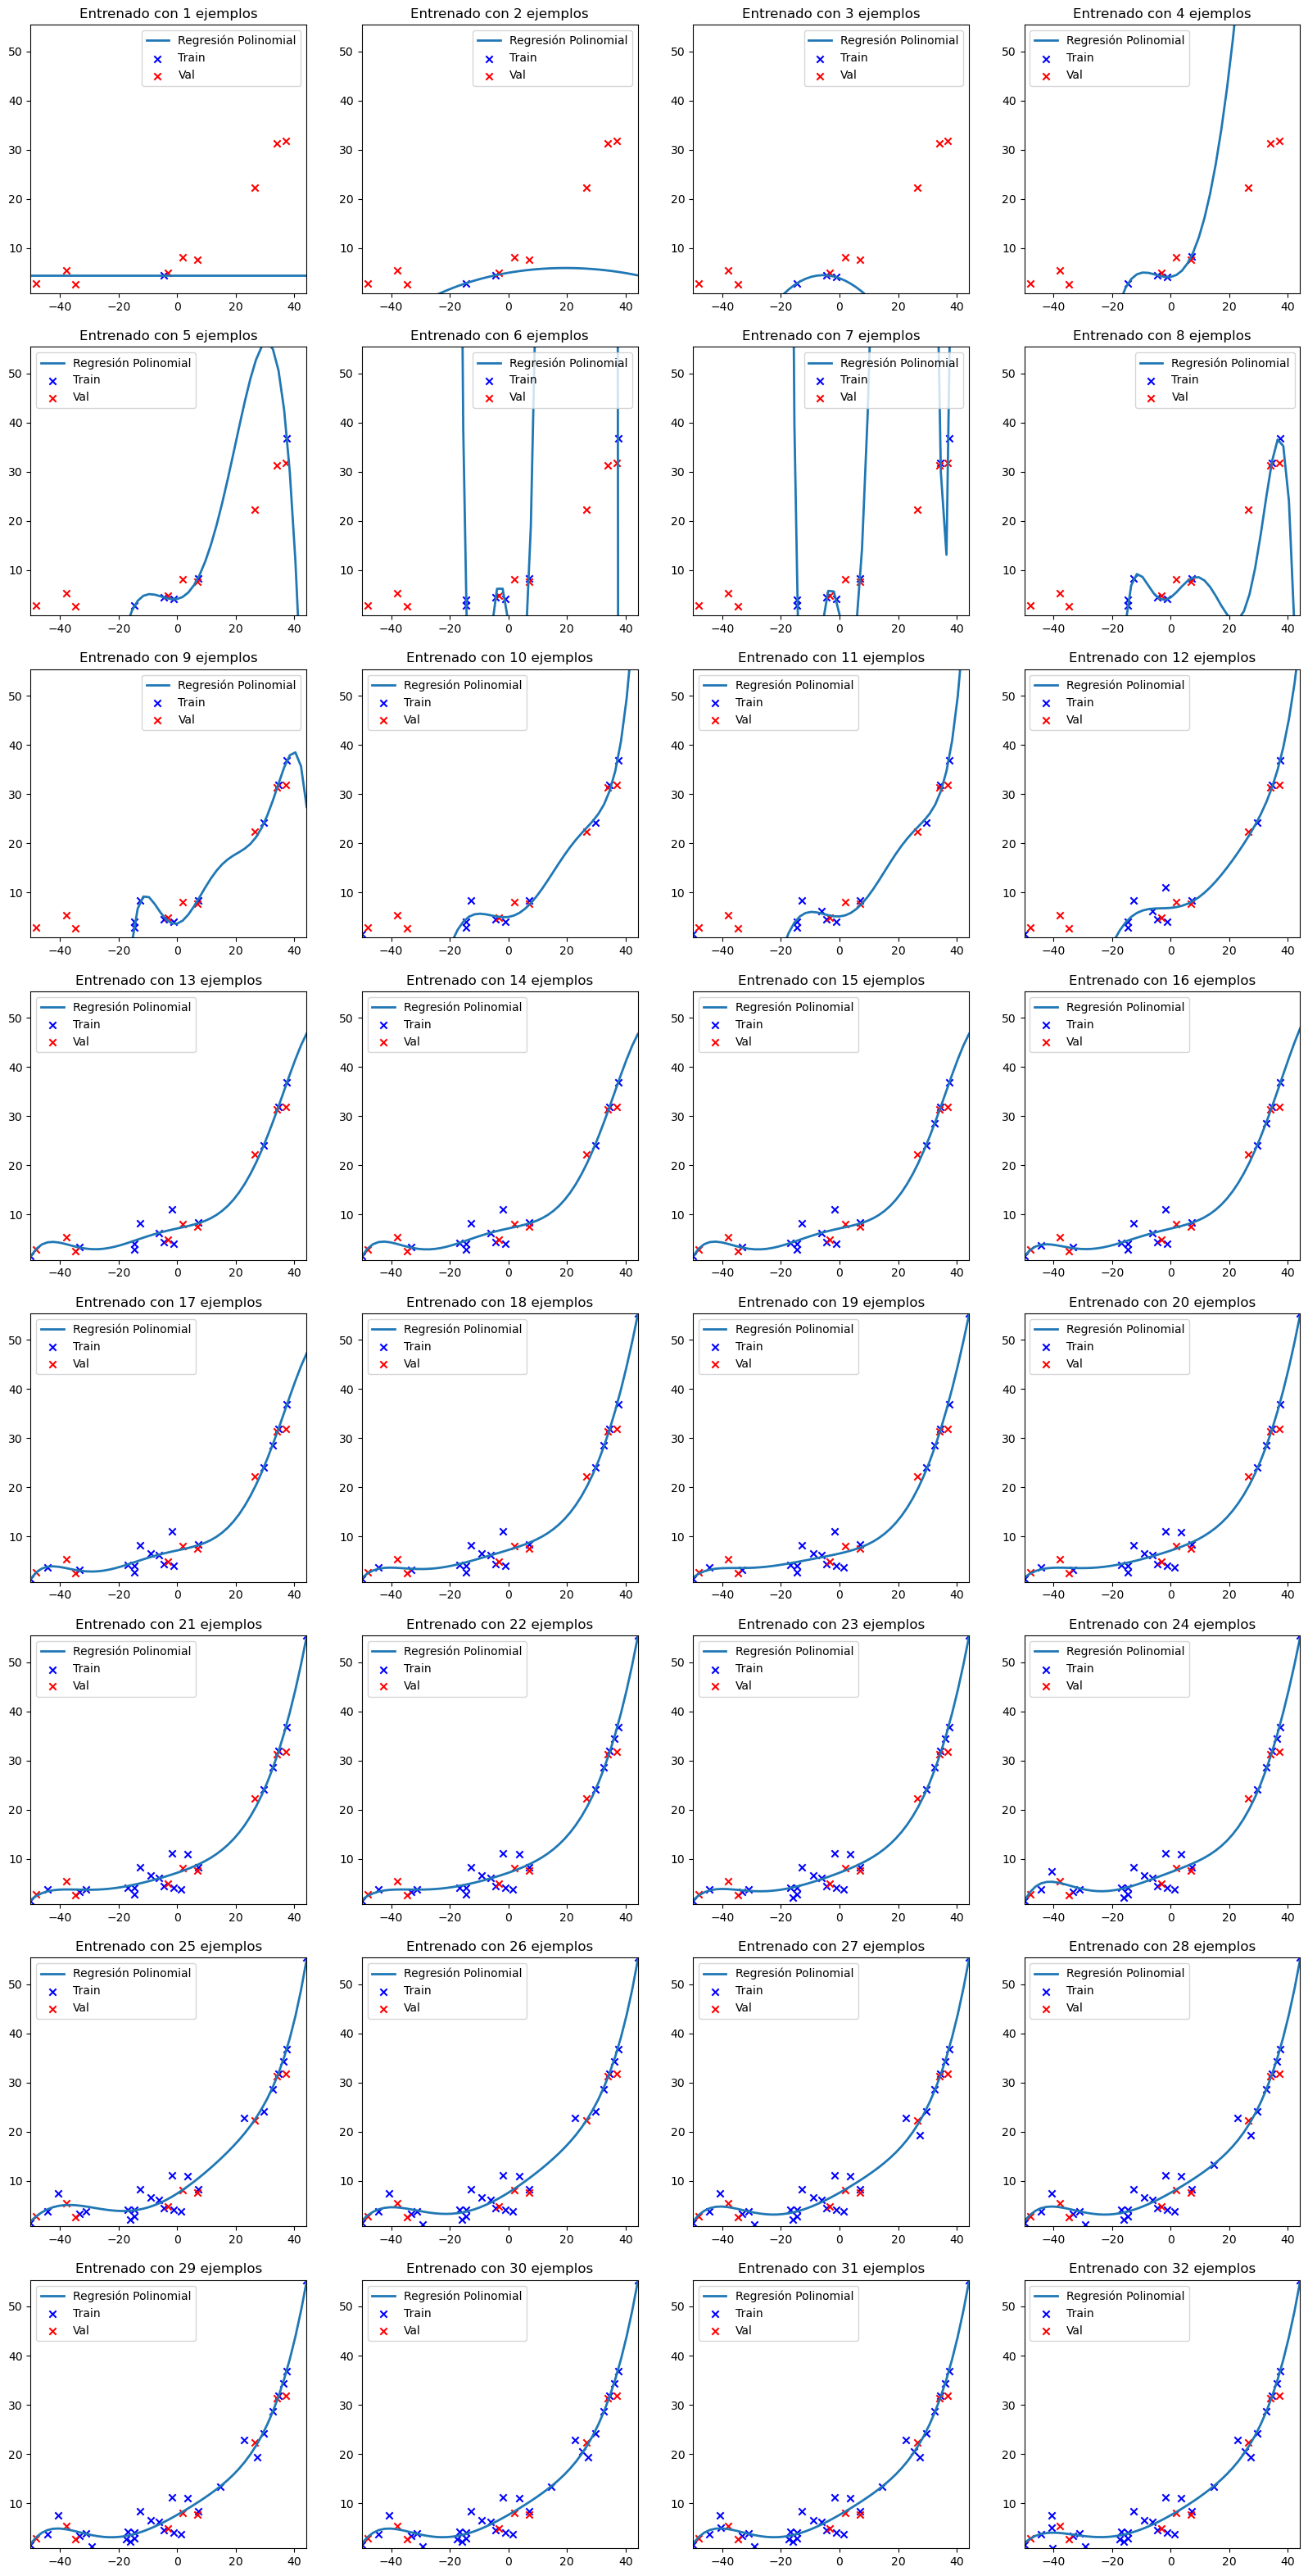

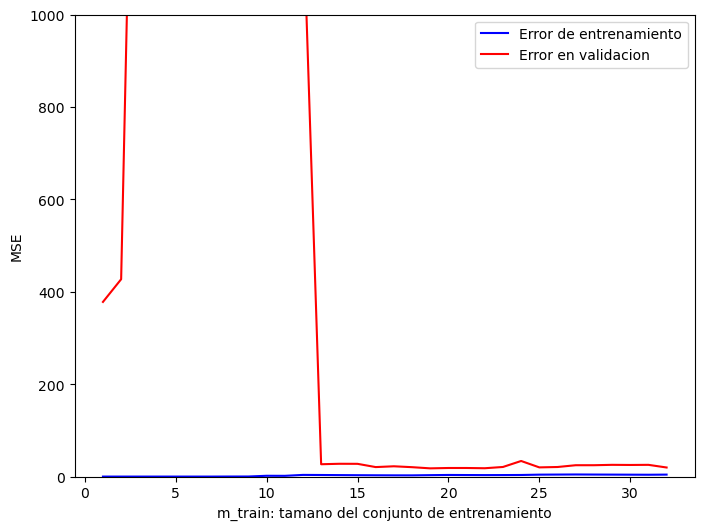

In [71]:
# Creamos objeto LinearRegression
reg = LinearRegression()

# Creamos dos arrays para almacenar los resultados de error en train y validación de tamaño m_train x 1 (train_err y val_err)
m_train = X_train.shape[0]
train_err = np.zeros(m_train)
val_err = np.zeros(m_train)
x_lim = [X_train.min(), X_train.max()]
y_lim = [y_train.min(), y_train.max()]
# Definimos una figura para pintar todos los resultados
fig, ax = plt.subplots(np.ceil(m_train / 4).astype('int'), 4, figsize=(20, 40)) 

# Comenzamos probando a entrenar la regresión con un solo ejemplo y realizamos la misma tarea hasta m_train
for i in range(0, m_train):
    # Ajustamos la regresión con los i primeros ejemplos (filas)
    reg.fit(X_train_poly[:i+1,:],y_train[:i+1])
    
    # Calculamos el error en train (SOBRE LOS i PRIMEROS EJEMPLOS) y validación
    y_predict_train = reg.predict(X_train_poly[:i+1,:])
    y_predict_val = reg.predict(X_val_poly)

    train_err[i] = mean_squared_error(y_predict_train,y_train[:i+1])
    val_err[i] = mean_squared_error(y_predict_val,y_val)
    # Pintamos en cada iteración la misma figura que en el apartado anterior con la recta aprendida en cada ocasión
    # Pon como título de cada subfigure el número de ejemplos utilizados para entrenar
    # Como hemos definido un subplot, utliza ax.ravel()[i] como eje para pintar la figura
    eje_actual = ax.ravel()[i]
    plot_linear_regression_sklearn(reg,x_lim,y_lim,poly,scaler,ax=eje_actual)
    plot_data(X_train=X_train[:i+1],y_train=y_train[:i+1], X_val=X_val, y_val=y_val,ax=eje_actual)
    eje_actual.set_title(f'Entrenado con {i+1} ejemplos')
    

# Ahora con todos los errores en train_err y val_err, pintamos la curva de aprendizaje
# En el eje X debemos tener el número de ejemplos utilizados para el entrenamiento (de 1 a m_train) y en el eje y
# debe de aparecer el error obtenido. Pintamos con diferente color cada error (train/val)
plt.figure(figsize=(8, 6))
eje_x = np.arange(1, m_train+1)

plt.plot(eje_x, train_err, c='blue', label='Error de entrenamiento')
plt.plot(eje_x, val_err, c='red',label='Error en validacion')

# Establecemos las etiquetas
plt.xlabel('m_train: tamano del conjunto de entrenamiento')
plt.ylabel('MSE')
plt.legend()
plt.ylim(0, 1000)

In [72]:
test_nb(list(np.round(train_err, 4)), [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1212,
       0.1702, 1.7356, 1.6154, 3.6295, 3.4369, 3.1917, 2.9789, 2.7968,
       2.6665, 2.6232, 3.0933, 3.5093, 3.344 , 3.2012, 3.2794, 3.4615,
       4.1762, 4.3601, 4.5552, 4.3926, 4.2559, 4.1159, 3.9835, 4.2643], 'Errores en train erróneos')
test_nb(list(np.round(val_err[13:], 4)), [27.7134, 27.5988, 20.5551, 22.2902, 20.3531, 17.8096, 18.5904,
       18.5818, 18.0612, 20.8003, 33.7651, 19.908 , 20.7217, 24.5948,
       24.5886, 25.418 , 25.1414, 25.4131, 19.6619], 'Errores en test erróneos')

✔️ Test passed.
✔️ Test passed.


### Seleccionando el valor de lambda usando el conjunto de validación <a id="lambdasel"></a>
Vamos a utilizar ahora el conjunto de validación para establecer el mejor valor de lambda, cuya capacidad de generalización evaluaremos posteriormente en el conjunto de test.

En este apartado debes:
1. Mostrar el resultado obtenido gráficamente (la mejor regresión obtenida)
2. Mostrar los errores para cada conjunto (train/val/test) para cada valor de lambda, tanto gráficamente como por pantalla utilizando la librería panda

Para ello debes realizar un bucle en el que entrenes la regresión lineal con regularización con diferentes valores de lambda ($\lambda$). Debes hacer uso de la clase [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) de scikit-learn, que es la regresión lineal con regularización y cuyo parámetro `alpha` es el parámetro lambda ($\lambda$) de regularización.

En cada iteración del bucle, crearemos la regresión lineal  con el valor de $\lambda$ correspondiente y la ajustaremos al conjunto de entrenamiento. Posteriormente, debemos obtener los errores para train/val/test. 
> **Nota:** Siempre mantendremos como mejor regresión aquella que nos ha dado el menor error de validación.

> **Nota 2:** Como es lógico, para buscar el mejor valor de lambda utilizaremos el conjunto de datos con las variables polinomiales.

In [ ]:
# Importamos Ridge que es la regresión lineal con regularización
from sklearn.linear_model import Ridge

# Aprende el mejor valor de lambda entre:
lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])

# Inicializamos los valores
best_reg = None
best_err = float('inf')
best_lambda = None
# Inicializa los arrays para los errores (train_err, val_err y test_err)
# Inicializa también best_err y best_lambda
train_err = np.zeros(lambda_vec.size)
test_err = np.zeros(lambda_vec.size)
val_err = np.zeros(lambda_vec.size)

for i in range(0, lambda_vec.size):
    # Obtenemos el valor de lambda a utilizar
    lambda_val = lambda_vec[i]
    # Creamos el objeto Ridge con dicho valor de lambda
    reg = Ridge(alpha=lambda_val)
    # Ajustamos la regresión
    reg.fit(X_train_poly,y_train)
    # Calculamos los errores de train/val/test
    y_pred_train = reg.predict(X_train_poly)
    y_pred_val = reg.predict(X_val_poly)
    y_pred_test = reg.predict(X_test_poly)

    train_err[i] = mean_squared_error(y_pred_train, y_train)
    test_err[i] = mean_squared_error(y_pred_test, y_test)
    val_err[i] = mean_squared_error(y_pred_val, y_val)


    # En caso de ser el mejor modelo encontrado, guardamos el mejor error, la regresión y el valor de lambda
    # if (.... < best_err): ... Actualizar best_err, bestlinear_reg y best_lambda
    if val_err[i] < best_err:
        best_err = val_err[i]
        best_reg = reg
        best_lambda = lambda_val
    

print(train_err)
print(val_err)
print(test_err)

[4.26434127 4.26435512 4.26446288 4.26558494 4.27338405 4.32007519
 4.43739949 4.64525045 5.19907301 8.84263864]
[19.66191246 19.58834378 19.4433441  18.95876801 17.7628252  15.09918189
 12.20549402  9.8702367   7.5897788   4.46785542]
[ 9.42977227  9.43765992  9.45321939  9.50563919  9.64137727 10.00530177
 10.56563508 11.18885272 11.68438221 13.24721686]


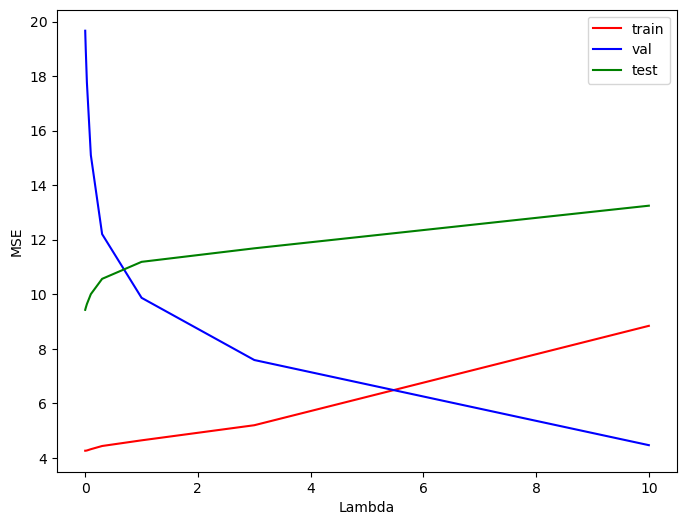

In [79]:
# Pintamos también una figura en la que en el eje x aparezcan los diferentes valores de lambda y en el eje y los
# diferentes errores obtenidos en cada uno de los conjuntos (mostrar cada uno con un color diferente).

fig,ax = plt.subplots(figsize=(8, 6))
plt.plot(lambda_vec, train_err,c='red',label='Error de entrenamiento')
plt.plot(lambda_vec,val_err,c='blue',label='Error de val')
plt.plot(lambda_vec,test_err,c='green',label='Error de test')

# Establecemos las etiquetas y la leyenda
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.legend(['train', 'val', 'test']);

<Axes: >

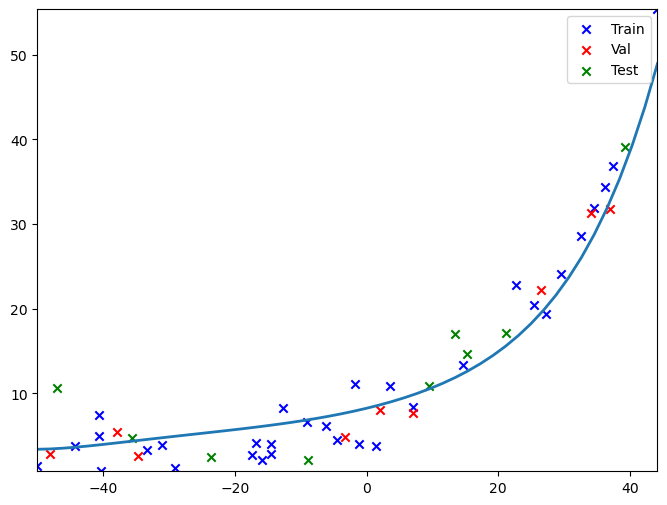

In [81]:
# Pintamos la figura que muestre todos los datos de train/val/test (cada uno de un color) y la mejor regresión
# obtenida.

fig, ax = plt.subplots(figsize=(8,6))

plot_data(X_train, y_train, X_val, y_val, X_test, y_test, ax=ax)

plot_linear_regression_sklearn(best_reg, x_lim, y_lim, poly, scaler, ax=ax)


In [83]:
# Finalmente, vamos a mostrar los datos de la última figura en forma de tabla utilizando los Pandas

# Concatenamos horizontalmente los datos a mostrar (hstack de las variable train_err, val_err y test_err
# con su correspondiente reshape a -1, 1)
# datos_pd = ...
datos_pd = np.column_stack((train_err.reshape(-1,1),val_err.reshape(-1,1),test_err.reshape(-1,1)))
# Creamos los nombres de las columnas, una lista con los strings Train, Validation, Test
# nombre_columnas = ...
nombre_columnas = ['Train','Validation','Test']
# Importamos la librería de pandas ya que no lo hemos hecho anteriormente
import pandas as pd

# Generamos el dataframe con data=datos_pd, index=lambda_vec y columns=nombre_columnas
datosPanda = pd.DataFrame(data=datos_pd, index=lambda_vec, columns=nombre_columnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Lambda'
# Mostramos el dataframe generado
print(datosPanda)

           Train  Validation       Test
Lambda                                 
0.000   4.264341   19.661912   9.429772
0.001   4.264355   19.588344   9.437660
0.003   4.264463   19.443344   9.453219
0.010   4.265585   18.958768   9.505639
0.030   4.273384   17.762825   9.641377
0.100   4.320075   15.099182  10.005302
0.300   4.437399   12.205494  10.565635
1.000   4.645250    9.870237  11.188853
3.000   5.199073    7.589779  11.684382
10.000  8.842639    4.467855  13.247217


Como verás, no siempre el mejor resultado de validación nos lleva al mejor resultado en test. En este caso, este hecho es más acusado por los pocos datos que tiene el problema. Por ello, suele ser habitual repetir el proceso con varias particiones distintas de train y validación, logrando un mejor ajuste de híper-parámetros.

In [84]:
test_nb(list(np.round(train_err, 4)), [4.2643, 4.2644, 4.2645, 4.2656, 4.2734, 4.3201, 4.4374, 4.6453,
       5.1991, 8.8426], 'Errores en train erróneos')
test_nb(list(np.round(val_err, 4)), [19.6619, 19.5883, 19.4433, 18.9588, 17.7628, 15.0992, 12.2055,
        9.8702,  7.5898,  4.4679], 'Errores en validación erróneos')
test_nb(list(np.round(test_err, 4)), [ 9.4298,  9.4377,  9.4532,  9.5056,  9.6414, 10.0053, 10.5656,
       11.1889, 11.6844, 13.2472], 'Errores en test erróneos')

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## Pipelines de Scikit-learn <a id="pipelines"></a>
Python y más concretamente scikit, tiene un clase denominada [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) que permite concatenar una serie de procesos que queramos aplicar a los datos como transformaciones (`PolynomialFeatures`, `StandardScaler`) o un clasificador o regresor (`Ridge`).

De esta forma nos ahorramos el tener que aplicar el mismo proceso a los datos de train, validación y test cada vez, ya que lo realiza el automáticamente.

Primero, creamos una pipeline con las fases deseadas. Por ejemplo, para crear una pipeline que primero cree las variable polinomiales con grado 6, luego estandarice los datos y aprenda la regresión lineal con regularización (con el mejor valor de $\lambda$ encontrado anteriormente) simplemente debemos escribir la siguiente instrucción:

```python
pipe = Pipeline([('variablesPoly', PolynomialFeatures(degree=6, include_bias=False)), ('StandardScaler', StandardScaler()), ('Ridge', Ridge(alpha=best_lambda))])
```

Es decir, la pipeline recibe una lista con los procesos a realizar, en la que en cada proceso tenemos una tupla con su nombre y el constructor a aplicar.

Posteriormente, solo debemos usar fit y predict:
* **fit:** Al aplicar fit, la pipeline hará un fit_tranform para obtener las variables polinomiales y otro para estandarizar los datos. Finalmente, en el caso de la regresión aplicará el fit para entrenarla.
* **predict:** predict se aplica tras aplicar fit a la pipeline. En este caso, scikit sabe que solo debe aplicar transform para obtener las variables polinomiales y la estandarización. Finalmente, aplicará el predict del regresor para obtener el valor de los datos ya procesados.

Es decir, nos olvidamos de transformar independientemente los datos de train, validación y test.

¡Vamos a probar las `Pipelines`!

In [85]:
# Se importa la librería para utilizar la clase Pipeline
from sklearn.pipeline import Pipeline

# Se crea la pipeline con las 3 fases necesarias para solventar el problema (guárdala en pipe)
pipe = Pipeline([('variablesPoly', PolynomialFeatures(degree=6,include_bias=False)),('StandardScaler',StandardScaler()),('Ridge', Ridge(alpha=best_lambda))])

# Se realiza el aprendizaje de todos los objetos de la pipeline. Utiliza pipe.fit(...)
pipe.fit(X_train, y_train)

# Se realiza la predicción de los datos de validación y test. Utiliza salidas = pipe.predict(...)
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)
y_test_pred = pipe.predict(X_test)


# Utilizamos mean_squared_error(y_pred, y_true) para obtener 
# los errores de train, validación y test
err_train = mean_squared_error(y_train_pred,y_train)
err_val = mean_squared_error(y_val_pred,y_val)
err_test = mean_squared_error(y_test_pred,y_test)

# Imprimimos los resultados
print('Error en train: {}'.format(err_train))
print('Error en train: {}'.format(err_val))
print('Error en train: {}'.format(err_test))

Error en train: 8.842638641819676
Error en train: 4.467855416270297
Error en train: 13.24721685618723


In [86]:
# Comprobamos que son iguales pero que nuestra medida de error es la mitad de lo que nos devuelve scikit
test_nb(np.round(err_train, 4), 8.8426, 'Errores en train erróneo')
test_nb(np.round(err_val, 4), 4.4679, 'Errores en val erróneo')
test_nb(np.round(err_test, 4), 13.2472, 'Errores en test erróneo')

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## GridSearchCV <a id="gridsearch"></a>

A la hora de buscar los hiperparámetros óptimos, es poco habitual que programemos bucles for a mano. Librerías como scikit-learn nos permiten automatizar el trabajo, por ejemplo, a través de la clase [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), a la que solo tenemos que darle los valores a probar y la forma de realizar el particionamiento.

Los parámetros principales que tenemos que pasarle son:
* `estimator`: El modelo cuyo rendimiento queremos estimar. En nuestro caso, reutilizaremos el pipeline de la sección de [Pipelines-de-Python](#Pipelines-de-Python).
* `scoring`: La medida de rendimiento que queremos utilizar. Lo más sencillo es escoger alguna de [estas](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), en nuestro caso la vamos a fijar a `neg_mean_squared_error`.
* `cv`: La forma de particionar los datos de entrenamiento. Aunque hasta ahora hemos usado las particiones train/val/test, en este caso scikit nos facilita mucho realizar una validación cruzada donde repetimos el proceso de dividir el train en train y validación para obtener una mejor estimación del error. Por ello, dejaremos el sistema por defecto (cross-validation con 5 particiones).
* `return_train_score`: Si queremos obtener también el rendimiento en `train`.
* `param_grid`: Diccionario que indica para cada parámetro (clave), qué valores hay que probar.
* `refit`: Parámetro que indica si queremos entrenar un modelo final con todos los datos después de encontrar la mejor configuración de híper-parámetros.

**Nota:** `GridSearchCV` funciona como un modelo más y requiere instanciar el objeto y usar posteriormente el método `fit()`.



In [87]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

# Se crea la pipeline con las 3 fases necesarias para solventar el problema (guárdala en pipe)
pipe = Pipeline([('variablesPoly', PolynomialFeatures(degree=6,include_bias=False)),('StandardScaler',StandardScaler()),('Ridge', Ridge(alpha=best_lambda))])

# Definimos lambda_vec y además creamos un nuevo array para los grados, con un np.arange de 1 a 20
grados_vec = np.arange(1, 20)
lambda_vec = np.array([0.0001, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])

# Creamos el diccionario con las dos variables a explorar. Utiliza la ayuda de scikit-lear para completar este paso
parameters = {'variablesPoly__degree': grados_vec, 'Ridge__alpha': lambda_vec}

# Finalmente lanzamos la búsqueda creando el objeto GridSearchCV, y haciendo fit sobre X_train3, y_train3
grid_search = GridSearchCV(estimator=pipe, scoring='neg_mean_squared_error',return_train_score=True, param_grid=parameters)
grid_search.fit(X_train,y_train)
# Extraemos el mejor estimador (aquel con los híper-parámetros con menor error) del objeto GridSearchCV (best_estimator_)
best_model = grid_search.best_estimator_

# Obtenemos el mejor grado (guárdalo como best_degree) y el mejor lambda (guárdalo como best_lambda) del estimador
best_degree = best_model['variablesPoly'].degree
best_lambda = best_model['Ridge'].alpha

print('Mejor grado del polinomio: {}'.format(best_degree))
print('Mejor valor de lambda: {}'.format(best_lambda))

# Predecimos para la partición de entrenamiento y obtenemos el erro con metrics.mean_squared_error
y_pred_train = best_model.predict(X_train)
train_err = mean_squared_error(y_pred_train, y_train)

# Predecimos para la partición de test
y_pred_test = best_model.predict(X_test)
test_err = mean_squared_error(y_test, y_pred_test)

print('Error en train: {}'.format(train_err))
print('Error en test: {}'.format(test_err))

Mejor grado del polinomio: 12
Mejor valor de lambda: 1.0
Error en train: 4.309198207110793
Error en test: 9.868044940659013


In [88]:
test_nb(best_degree == 12, True, 'Mejor grado incorrecto')
test_nb(best_lambda == 1.0, True, 'Mejor lambda incorrecto')
test_nb(round(train_err, 4) == 4.3092, True, 'Error en train erróneo')
test_nb(round(test_err, 4) == 9.8680, True, 'Error en test erróneo')

✔️ Test passed.
✔️ Test passed.
✔️ Test passed.
✔️ Test passed.


## Otros recursos vistos en clase también disponibles en scikit-learn

Sci-kit también incluye herramientas para calcular las curvas de validación y las curvas de aprendizaje que hemos visto en teoría. En concreto, puedes buscar más información sobre:

 - [`model_selection.learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html), que entrena y evalua automáticamente el modelo con diferentes cantitades de datos.
 - [`model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html), que entrena y evalua automáticamente el modelo con diferentes valores de un parámetro concreto.
 
